In [1]:
import pandas as pd

def train_test_split_time(df: pd.DataFrame, aus_port: str, for_port: str, test_length: int = 9):
    """
    Splits time-series data into train and test sets for a given city pair.

    Parameters:
        df: DataFrame with the dataset!
        aus_port: It refers to the Australian Port provided in the route.
        for_port: It refers to the Foreign Port provided in the route.
        horizon (int): Number of months to keep for testing. Kept as 9 (in between 6-12 months).
    """
    route_df = (df[((df["AustralianPort"] == aus_port) & (df["ForeignPort"] == for_port))]
                .sort_values("MonthYear").reset_index(drop=True))

    train = route_df.iloc[:-test_length]
    test = route_df.iloc[-test_length:]

    return train, test

In [66]:
df = pd.read_csv("../../data/aeroconnect_cleaned.csv")
train, test = train_test_split_time(df=df, aus_port="Sydney", for_port="Auckland")

print("Train range:", train["MonthYear"].min(), "→", train["MonthYear"].max())
print("Test range:", test["MonthYear"].min(), "→", test["MonthYear"].max())

Train range: 1985-01-01 → 1988-09-01
Test range: 1988-10-01 → 1989-06-01


In [74]:
def create_lag_features(series, n_lags=12):
    """
    This method prepares the input for time-series forecasting by creating "lag features". Each lag column corresponds to value of "PassengersTotal" from previous time-steps, which can be used as predictors for the current value.
    :param series: DataFrame.
    :param n_lags: Number of lagged time-steps to generate features for.
    :return: DataFrame with lag features!!
    """
    df = pd.DataFrame(series)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df['PassengersTotal'].shift(lag)
    df = df.dropna()
    return df

In [75]:
df_lagged = create_lag_features(train[['PassengersTotal']], n_lags=12)

X = df_lagged.drop(columns=['PassengersTotal'])
y = df_lagged['PassengersTotal']

test_size = min(9, len(df_lagged)//2)
train = df_lagged.iloc[:-test_size]
test = df_lagged.iloc[-test_size:]

In [89]:
import torch
import torch.nn as nn

def run_nn_forecast(X_train, X_test, y_train, y_test):
    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test.values, dtype=torch.float32)

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for i in range(100):
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = loss_fn(output, y_train_t)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        preds = model(X_test_t).numpy().flatten()

    results = pd.DataFrame({
        "Actual": y_test.values,
        "Predicted": preds
    })
    results["AbsError"] = abs(results["Actual"] - results["Predicted"])
    results["Accuracy"] = 1 - results["AbsError"] / results["Actual"]

    total_error = results["AbsError"].sum()
    mean_acc = results["Accuracy"].mean() * 100

    print(f"Total Absolute Error: {total_error}")
    print(f"Mean Accuracy: {mean_acc:.2f} %")
    return results


In [90]:
X_train = train.drop(columns='PassengersTotal')
y_train = train['PassengersTotal']
X_test = test.drop(columns='PassengersTotal')
y_test = test['PassengersTotal']

results = run_nn_forecast(X_train, X_test, y_train, y_test)

Total Absolute Error: 25943.03125
Mean Accuracy: 93.43 %


In [95]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def plot_port_pair_forecast_nn(df, aus_port, foreign_port, n_lags=12, min_history=24):
    """
    Train a simple feedforward NN for a port-pair, predict, compute absolute error & accuracy,
    and plot results (train, test, forecast) in same style as RF/Linear Regression.
    """
    # --- Prepare data ---
    group = df[(df["AustralianPort"] == aus_port) & (df["ForeignPort"] == foreign_port)]
    group = group.sort_values("MonthYear")

    if len(group) < min_history:
        print(f"Not enough history for {aus_port}-{foreign_port}")
        return

    df_lags = create_lag_features(group['PassengersTotal'], n_lags=n_lags)
    if len(df_lags) < 2:
        print(f"Not enough lagged data for {aus_port}-{foreign_port}")
        return

    # --- Split train/test ---
    test_size = min(9, len(df_lags)//2)
    train = df_lags.iloc[:-test_size]
    test = df_lags.iloc[-test_size:]

    X_train = train.drop(columns='PassengersTotal').values.astype(np.float32)
    y_train = train['PassengersTotal'].values.astype(np.float32).reshape(-1,1)
    X_test = test.drop(columns='PassengersTotal').values.astype(np.float32)
    y_test = test['PassengersTotal'].values.astype(np.float32).reshape(-1,1)

    X_train_t = torch.from_numpy(X_train)
    y_train_t = torch.from_numpy(y_train)
    X_test_t = torch.from_numpy(X_test)

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        forecast = model(X_test_t).numpy().flatten()

    results = pd.DataFrame({
        "Actual": y_test.flatten(),
        "Predicted": forecast
    })
    results["AbsError"] = abs(results["Predicted"] - results["Actual"])
    results["Accuracy"] = 1 - (results["AbsError"] / results["Actual"])

    total_abs_error = results["AbsError"].sum()
    mean_accuracy = results["Accuracy"].mean()

    plt.figure(figsize=(10,5))
    plt.plot(group["MonthYear"].iloc[n_lags: -test_size], y_train.flatten(), label="Train (Actual)", color="blue")
    plt.plot(group["MonthYear"].iloc[-test_size:], y_test.flatten(), label="Test (Actual)", color="black", linestyle="dashed")
    plt.plot(group["MonthYear"].iloc[-test_size:], forecast, label="Forecast (NN)", color="red")
    plt.title(f"Passenger Forecast (Neural Network): {aus_port} → {foreign_port}")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.ylabel("Passengers")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Total Absolute Error:", total_abs_error)
    print("Mean Accuracy:", round(mean_accuracy*100,2), "%")
    return results, total_abs_error, mean_accuracy


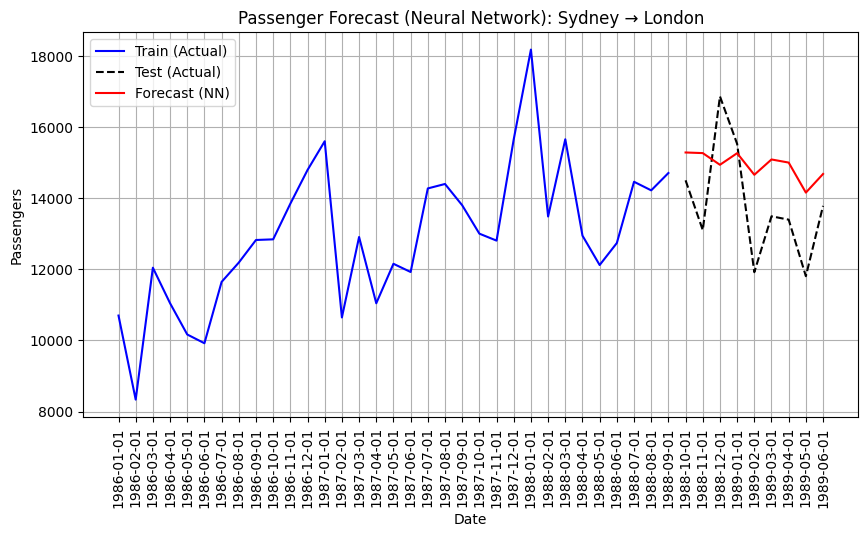

Total Absolute Error: 14317.702
Mean Accuracy: 87.98 %


In [115]:
results, total_error, mean_acc = plot_port_pair_forecast_nn(df, aus_port="Sydney", foreign_port="London")